In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

In [27]:
datatrain = pd.read_csv('data/yeast/yeast-train.csv')
datatest = pd.read_csv('data/yeast/yeast-test.csv')

datatrain.loc[datatrain['Class1'] =="b'0'", 'Class1'] = 0
datatrain.loc[datatrain['Class1'] =="b'1'", 'Class1'] = 1
datatest.loc[datatest['Class1'] =="b'0'", 'Class1'] = 0
datatest.loc[datatest['Class1'] =="b'1'", 'Class1'] = 1

dataset = pd.concat([datatrain, datatest], ignore_index=True)

In [28]:
X = dataset.drop(['Class1','Class2','Class3','Class4','Class5','Class6','Class7','Class8','Class9','Class10','Class11','Class12','Class13','Class14'],axis=1)
y = dataset['Class1']

In [29]:
X.shape

(2417, 103)

In [30]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [31]:
scaled_dataset = scaler.transform(X)

In [32]:
columns = 93

In [33]:
pca=PCA(n_components=columns)

In [34]:
pca.fit(scaled_dataset)

PCA(copy=True, iterated_power='auto', n_components=93, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [35]:
pca_dataset = pca.transform(scaled_dataset)

In [65]:
pca.explained_variance_ratio_.sum()

0.9916125918379054

In [36]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)

In [37]:
labels = ['PC'+str(i) for i in range(1,len(per_var)+1)]

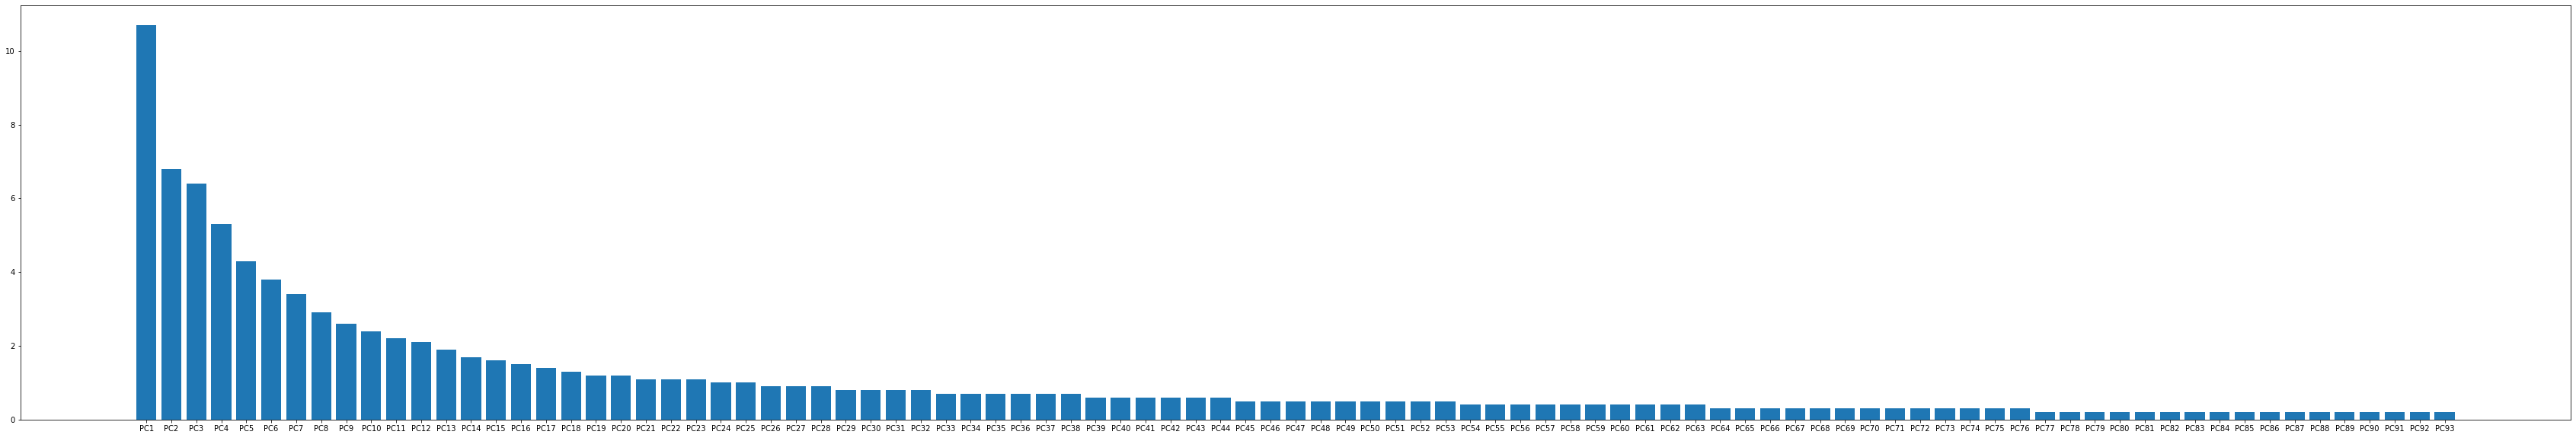

In [38]:
plt.subplots(figsize=(60,10))
plt.bar(x=range(1,len(per_var)+1), height=per_var,tick_label=labels)
plt.show()

In [39]:
pca_dataset.shape

(2417, 93)

In [40]:
pca_dataset

array([[-0.55176009, -4.11826903,  1.18775052, ...,  0.26797299,
         0.86944656,  0.6807798 ],
       [ 2.45756716,  4.83013454, -1.81767347, ..., -0.56915532,
        -0.43361272,  0.46762362],
       [-3.62100619, -3.89666324, -1.16289207, ...,  0.94660135,
         0.12207977,  0.42227216],
       ...,
       [ 1.81734371,  3.99589411,  1.50746277, ...,  0.11100891,
         0.32269603,  0.84470051],
       [ 0.11198037,  0.59823097,  6.76980941, ..., -0.47072085,
        -0.58193634, -0.05958187],
       [ 1.81616691, -2.727746  , -2.17586065, ..., -0.50054436,
         0.09600034, -0.51295775]])

In [41]:
y=y.values

In [42]:
random.seed(0)
X_train,X_test, y_train,y_test =train_test_split(pca_dataset,y,test_size=0.2,random_state=0)
print(X_train.shape)
print(X_test.shape)

(1933, 93)
(484, 93)


In [33]:
a = [el/100 for el in range(1,101) ]


In [38]:
mxa=0
for i in a:
    xgbclassifier = XGBClassifier(learning_rate=i)
    xgbclassifier.fit(X_train, y_train)
    y_pred = xgbclassifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    if accuracy>mxa:
        mxa=accuracy
        print(mxa,i)

0.7334710743801653 0.01
0.743801652892562 0.02
0.7541322314049587 0.03
0.762396694214876 0.05
0.7665289256198347 0.06
0.768595041322314 0.09
0.7706611570247934 0.14
0.7747933884297521 0.23


In [41]:
from sklearn.svm import SVC

svmclassifier = SVC(kernel='linear' ,random_state=0)
svmclassifier.fit(X_train,y_train)
y_pred_svm = svmclassifier.predict(X_test)

cm = confusion_matrix(y_test,y_pred_svm)
print(cm)
accuracy=accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[309  21]
 [ 84  70]]
Accuracy: 78.31%


In [42]:
from sklearn.ensemble import RandomForestClassifier
mxa = 0
for i in range(1,51):
    rfclassifier = RandomForestClassifier(n_estimators=i*5,criterion='entropy',random_state=0)
    rfclassifier.fit(X_train,y_train)
    y_pred_randForest = rfclassifier.predict(X_test)
    accuracy=accuracy_score(y_test, y_pred_randForest)
    if accuracy>mxa:
        mxa=accuracy
        print(accuracy,(i*5))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.6838842975206612 5
0.7355371900826446 10
0.756198347107438 25
0.7644628099173554 35
Accuracy: 74.59%


In [1]:
# Packages for training model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import model_from_json
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization

# Packages for explanation
from keras import backend as K
from keras.models import Model
from deepexplain.tensorflow import DeepExplain
from IPython.display import display, HTML
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [43]:
sgdOptimizer = 'adam'
lossFun='categorical_crossentropy'
finalLayerActivation = 'softmax'
batchSize=25
numEpochs = 500
inputDim=columns
nb_classes = 2

In [56]:
trainY=np_utils.to_categorical(y_train, num_classes = nb_classes)
testY=np_utils.to_categorical(y_test, num_classes = nb_classes)

In [47]:
model = Sequential()
model.add(BatchNormalization(input_shape=(inputDim,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nb_classes, activation=finalLayerActivation))
model.compile(loss=lossFun, optimizer=sgdOptimizer, metrics=["accuracy"])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 93)                372       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3008      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)  

In [58]:
model.fit(X_train,trainY,validation_data=(X_test,testY) ,batch_size=batchSize, epochs=numEpochs, verbose=1)
trainScore = model.evaluate(X_train,trainY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], trainScore[1]*100))
testScore = model.evaluate(X_test,testY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], testScore[1]*100))

Train on 1933 samples, validate on 484 samples
Epoch 1/500
1933/1933 [==============================] - 1s 295us/step - loss: 0.3172 - acc: 0.8655 - val_loss: 0.5988 - val_acc: 0.7769
Epoch 2/500
1933/1933 [==============================] - 1s 261us/step - loss: 0.3307 - acc: 0.8505 - val_loss: 0.5972 - val_acc: 0.7769
Epoch 3/500
1933/1933 [==============================] - 1s 259us/step - loss: 0.3028 - acc: 0.8702 - val_loss: 0.6078 - val_acc: 0.7789
Epoch 4/500
1933/1933 [==============================] - 1s 268us/step - loss: 0.3309 - acc: 0.8645 - val_loss: 0.6382 - val_acc: 0.7769
Epoch 5/500
1933/1933 [==============================] - 1s 275us/step - loss: 0.2982 - acc: 0.8707 - val_loss: 0.6399 - val_acc: 0.7789
Epoch 6/500
1933/1933 [==============================] - 1s 266us/step - loss: 0.3419 - acc: 0.8572 - val_loss: 0.5868 - val_acc: 0.7810
Epoch 7/500
1933/1933 [==============================] - 1s 267us/step - loss: 0.3262 - acc: 0.8665 - val_loss: 0.5831 - val_acc: 0

1933/1933 [==============================] - 0s 255us/step - loss: 0.3188 - acc: 0.8583 - val_loss: 0.5849 - val_acc: 0.7872
Epoch 61/500
1933/1933 [==============================] - 0s 240us/step - loss: 0.3111 - acc: 0.8670 - val_loss: 0.6055 - val_acc: 0.8017
Epoch 62/500
1933/1933 [==============================] - 1s 260us/step - loss: 0.3100 - acc: 0.8593 - val_loss: 0.5969 - val_acc: 0.7934
Epoch 63/500
1933/1933 [==============================] - 0s 259us/step - loss: 0.3217 - acc: 0.8603 - val_loss: 0.5789 - val_acc: 0.7872
Epoch 64/500
1933/1933 [==============================] - 0s 250us/step - loss: 0.3288 - acc: 0.8665 - val_loss: 0.5761 - val_acc: 0.7851
Epoch 65/500
1933/1933 [==============================] - 0s 248us/step - loss: 0.3141 - acc: 0.8681 - val_loss: 0.5816 - val_acc: 0.7913
Epoch 66/500
1933/1933 [==============================] - 1s 269us/step - loss: 0.3272 - acc: 0.8557 - val_loss: 0.5894 - val_acc: 0.7851
Epoch 67/500
1933/1933 [=======================

1933/1933 [==============================] - 0s 230us/step - loss: 0.3294 - acc: 0.8639 - val_loss: 0.5925 - val_acc: 0.7831
Epoch 179/500
1933/1933 [==============================] - 0s 229us/step - loss: 0.3210 - acc: 0.8624 - val_loss: 0.5742 - val_acc: 0.7872
Epoch 180/500
1933/1933 [==============================] - 0s 241us/step - loss: 0.2885 - acc: 0.8810 - val_loss: 0.6350 - val_acc: 0.7851
Epoch 181/500
1933/1933 [==============================] - 0s 245us/step - loss: 0.2974 - acc: 0.8614 - val_loss: 0.6076 - val_acc: 0.7789
Epoch 182/500
1933/1933 [==============================] - 0s 226us/step - loss: 0.3078 - acc: 0.8598 - val_loss: 0.6026 - val_acc: 0.7851
Epoch 183/500
1933/1933 [==============================] - 0s 224us/step - loss: 0.3134 - acc: 0.8691 - val_loss: 0.5886 - val_acc: 0.7789
Epoch 184/500
1933/1933 [==============================] - 0s 231us/step - loss: 0.3041 - acc: 0.8670 - val_loss: 0.6319 - val_acc: 0.7810
Epoch 185/500
1933/1933 [================

1933/1933 [==============================] - 0s 227us/step - loss: 0.3084 - acc: 0.8614 - val_loss: 0.6333 - val_acc: 0.7665
Epoch 238/500
1933/1933 [==============================] - 0s 234us/step - loss: 0.3075 - acc: 0.8603 - val_loss: 0.6192 - val_acc: 0.7769
Epoch 239/500
1933/1933 [==============================] - 0s 237us/step - loss: 0.3106 - acc: 0.8655 - val_loss: 0.5987 - val_acc: 0.7707
Epoch 240/500
1933/1933 [==============================] - 0s 230us/step - loss: 0.2917 - acc: 0.8769 - val_loss: 0.6353 - val_acc: 0.7727
Epoch 241/500
1933/1933 [==============================] - 0s 227us/step - loss: 0.2967 - acc: 0.8748 - val_loss: 0.6480 - val_acc: 0.7789
Epoch 242/500
1933/1933 [==============================] - 0s 232us/step - loss: 0.3114 - acc: 0.8681 - val_loss: 0.6064 - val_acc: 0.7769
Epoch 243/500
1933/1933 [==============================] - 0s 231us/step - loss: 0.3148 - acc: 0.8608 - val_loss: 0.6038 - val_acc: 0.7789
Epoch 244/500
1933/1933 [================

1933/1933 [==============================] - 0s 229us/step - loss: 0.2855 - acc: 0.8753 - val_loss: 0.6725 - val_acc: 0.7748
Epoch 297/500
1933/1933 [==============================] - 0s 226us/step - loss: 0.2951 - acc: 0.8639 - val_loss: 0.6607 - val_acc: 0.7851
Epoch 298/500
1933/1933 [==============================] - 0s 222us/step - loss: 0.2830 - acc: 0.8846 - val_loss: 0.6638 - val_acc: 0.7996
Epoch 299/500
1933/1933 [==============================] - 0s 229us/step - loss: 0.2849 - acc: 0.8784 - val_loss: 0.6241 - val_acc: 0.7872
Epoch 300/500
1933/1933 [==============================] - 0s 237us/step - loss: 0.2995 - acc: 0.8660 - val_loss: 0.6273 - val_acc: 0.7872
Epoch 301/500
1933/1933 [==============================] - 0s 227us/step - loss: 0.3166 - acc: 0.8557 - val_loss: 0.6049 - val_acc: 0.7872
Epoch 302/500
1933/1933 [==============================] - 0s 232us/step - loss: 0.2922 - acc: 0.8738 - val_loss: 0.6259 - val_acc: 0.7872
Epoch 303/500
1933/1933 [================

1933/1933 [==============================] - 1s 261us/step - loss: 0.2992 - acc: 0.8784 - val_loss: 0.5999 - val_acc: 0.7686
Epoch 356/500
1933/1933 [==============================] - 1s 345us/step - loss: 0.3097 - acc: 0.8634 - val_loss: 0.6338 - val_acc: 0.7851
Epoch 357/500
1933/1933 [==============================] - 1s 324us/step - loss: 0.3015 - acc: 0.8598 - val_loss: 0.6027 - val_acc: 0.7727
Epoch 358/500
1933/1933 [==============================] - 1s 328us/step - loss: 0.2982 - acc: 0.8686 - val_loss: 0.6253 - val_acc: 0.7769
Epoch 359/500
1933/1933 [==============================] - 1s 259us/step - loss: 0.3102 - acc: 0.8614 - val_loss: 0.6360 - val_acc: 0.7893
Epoch 360/500
1933/1933 [==============================] - 0s 245us/step - loss: 0.3038 - acc: 0.8702 - val_loss: 0.6372 - val_acc: 0.7872
Epoch 361/500
1933/1933 [==============================] - 1s 282us/step - loss: 0.2996 - acc: 0.8753 - val_loss: 0.6558 - val_acc: 0.7810
Epoch 362/500
1933/1933 [================

1933/1933 [==============================] - 1s 261us/step - loss: 0.3098 - acc: 0.8660 - val_loss: 0.5884 - val_acc: 0.7686
Epoch 415/500
1933/1933 [==============================] - 0s 242us/step - loss: 0.3270 - acc: 0.8531 - val_loss: 0.6102 - val_acc: 0.7810
Epoch 416/500
1933/1933 [==============================] - 0s 248us/step - loss: 0.3153 - acc: 0.8660 - val_loss: 0.5940 - val_acc: 0.7707
Epoch 417/500
1933/1933 [==============================] - 1s 265us/step - loss: 0.2935 - acc: 0.8753 - val_loss: 0.6412 - val_acc: 0.7707
Epoch 418/500
1933/1933 [==============================] - 0s 251us/step - loss: 0.2892 - acc: 0.8738 - val_loss: 0.6267 - val_acc: 0.7686
Epoch 419/500
1933/1933 [==============================] - 0s 244us/step - loss: 0.3127 - acc: 0.8727 - val_loss: 0.5937 - val_acc: 0.7645
Epoch 420/500
1933/1933 [==============================] - 0s 250us/step - loss: 0.3070 - acc: 0.8645 - val_loss: 0.5889 - val_acc: 0.7707
Epoch 421/500
1933/1933 [================

1933/1933 [==============================] - 0s 257us/step - loss: 0.2932 - acc: 0.8733 - val_loss: 0.6431 - val_acc: 0.7624
Epoch 474/500
1933/1933 [==============================] - 0s 250us/step - loss: 0.2805 - acc: 0.8800 - val_loss: 0.6418 - val_acc: 0.7686
Epoch 475/500
1933/1933 [==============================] - 0s 248us/step - loss: 0.3076 - acc: 0.8603 - val_loss: 0.6354 - val_acc: 0.7727
Epoch 476/500
1933/1933 [==============================] - 0s 248us/step - loss: 0.3019 - acc: 0.8655 - val_loss: 0.6425 - val_acc: 0.7645
Epoch 477/500
1933/1933 [==============================] - 0s 252us/step - loss: 0.3036 - acc: 0.8733 - val_loss: 0.6401 - val_acc: 0.7769
Epoch 478/500
1933/1933 [==============================] - 0s 250us/step - loss: 0.3116 - acc: 0.8634 - val_loss: 0.6276 - val_acc: 0.7789
Epoch 479/500
1933/1933 [==============================] - 0s 255us/step - loss: 0.2964 - acc: 0.8665 - val_loss: 0.6301 - val_acc: 0.7851
Epoch 480/500
1933/1933 [================

In [59]:
score = model.evaluate(X_test,testY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 78.31%
